In [1]:
import geopandas as gpd # Geospatial data operations
import rasterio as rio # Geospatial imagery manipulation
import rasterio.plot
import pandas as pd # Tabular data
import os
import re
import rapidfuzz # Fuzzy string matching
from tqdm.auto import tqdm # Progress bars
import matplotlib # Plots
import matplotlib.pyplot as plt
import shapely # Polygon operations
import solaris.tile as tile # Tile splitting
import solaris.data.coco as coco
import contextlib
import io
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio import transform
matplotlib.rcParams['figure.figsize'] = (20, 10)
tqdm.pandas()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 130)

In [2]:
# A complete filelist of the MaxarImagery & Retrolens folders, generated with the unix command:
# find MaxarImagery/ Retrolens/ > ressci201900060-RNC2-Coastal_MaxarImagery_Retrolens_filelist.txt
filelist = pd.read_csv("ressci201900060-RNC2-Coastal_MaxarImagery_Retrolens_filelist.txt", header=None).iloc[:,0]
filelist

0                                                                         MaxarImagery/
1                                                              MaxarImagery/._.DS_Store
2                                                                 MaxarImagery/HighFreq
3                                                       MaxarImagery/HighFreq/HawkesBay
4                                           MaxarImagery/HighFreq/HawkesBay/._.DS_Store
                                              ...                                      
141473            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2
141474    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2.aux.xml
141475    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_22AUG1961_mosaic.tif.aux.xml
141476    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_20SEP1980_mosaic.jp2.aux.xml
141477        Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_04APR1986_mosaic.jp2.ovr
Name: 0, Length: 141478, dtype: 

In [3]:
def check_filename(filename):
    if "Taranaki" in filename:
        return False
    else:
        # This regex only matches shapefiles that contain something date-like in their names
        match = re.search(r'/Shorelines/\w+\d\w+\d{4}\w*.shp$', filename)
        return bool(match)

df = filelist[filelist.apply(check_filename)].to_frame(name="filename")
df

,filename
1344,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_13DEC2013.shp
1368,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_22NOV2017.shp
1371,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_14DEC2006.shp
1375,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_18MAR2021.shp
1385,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_08FEB2016.shp
...,...
140219,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_29OCT1973.shp
140221,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_15APR1966.shp
140224,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_17APR1952.shp
140278,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_02JAN1988.shp


In [4]:
images = filelist[filelist.str.contains("/Stack/", case=False) & filelist.str.endswith((".jpg", ".jp2", ".tif"))]
images

236       MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_08NOV2019_2.tif
237       MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_08NOV2019_1.tif
239         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_12MAR2018.tif
242         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_31AUG2005.tif
254         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_25DEC2015.tif
                                              ...                                      
141460            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_19NOV1972_mosaic.jp2
141466            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_04APR1986_mosaic.jp2
141469            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_10NOV1977_mosaic.tif
141470            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_22AUG1961_mosaic.tif
141473            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2
Name: 0, Length: 1904, dtype: ob

In [5]:
# When fuzzy matching, ignore these strings
# _0 will ignore leading zeros in dates
strings_to_delete = ["_mosaic", "_mosiac", "_mosaid", ".mosaic", "_cliff", "_beach", "_beachcliffsegment", "_MF.shp", "_MT.shp", "_0", "_1.tif", "_2.tif", "_3.tif", "_LDS", "_"]

def fuzz_preprocess(filename):
    for s in strings_to_delete:
        filename = filename.replace(s, "")
    # Case-insensitive
    filename = filename.lower()
    # Ignore extension
    filename = os.path.splitext(filename)[0]
    # Basename only
    filename = os.path.basename(filename)
    return filename

def get_matching_image(filename):
    dirname = os.path.dirname(filename)
    RL_dirname = dirname.replace("Stack/", "").replace("Shorelines", "Stack").replace("MaxarImagery/HighFreq", "Retrolens")
    Maxar_dirname = dirname.replace("Imagery/Shorelines", "Imagery/Stack").replace("Shorelines", "Imagery/Stack").replace("Retrolens", "MaxarImagery/HighFreq")
    Maxar_dirname_uppercase = Maxar_dirname.replace("Stack", "STACK")
    Maxar_dirname_outside_Imagery = Maxar_dirname.replace("Imagery/Stack", "Stack")
    all_files_in_folder = images[images.str.startswith((RL_dirname, Maxar_dirname, Maxar_dirname_uppercase, Maxar_dirname_outside_Imagery))]
    if len(all_files_in_folder) == 0:
        return "", 0
    match, score, index = rapidfuzz.process.extractOne(query=filename, choices=all_files_in_folder, processor=fuzz_preprocess)
    return match, score

df["matched_image"], df["match_score"] = zip(*df.filename.apply(get_matching_image))
print("Perfect matches:", sum(df.match_score == 100))
print("Imperfect matches:", sum(df.match_score < 100))
df[["filename", "matched_image", "match_score"]].sort_values(by="match_score").to_csv("shoreline_image_matching.csv", index=False)

Perfect matches: 776
Imperfect matches: 122


In [6]:
coastline = gpd.read_file("lds-nz-coastlines-and-islands-polygons-topo-150k-FGDB.zip!nz-coastlines-and-islands-polygons-topo-150k.gdb")

In [7]:
# Get a random (known-good) annotation
sample = df[df.match_score == 100].sample(1)
display(sample)
image_filename = sample.matched_image.iloc[0]
image = rio.open(image_filename)
sample_gdf = gpd.read_file(sample.filename.iloc[0])
sample_gdf

,filename,matched_image,match_score
109856,Retrolens/Canterbury/SouthNewBrighton/Stack/Shorelines/SouthNewBrighton_16AUG1950.shp,Retrolens/Canterbury/SouthNewBrighton/Stack/SouthNewBrighton_16AUG1950_mosaic.jp2,100.0


,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,geometry
0,0,Canterbury,SouthNewBrighton,1950-08-16,16/08/1950,TK,1500,Seawall,RL,"LINESTRING (1578276.140 5182925.104, 1578279.216 5182914.744, 1578278.422 5182913.950, 1578277.232 5182913.553, 1578276.835 51..."
1,0,Canterbury,SouthNewBrighton,1950-08-16,16/08/1950,TK,1500,EOV,RL,"LINESTRING (1578342.319 5182667.490, 1578343.113 5182661.537, 1578343.113 5182655.981, 1578343.907 5182650.028, 1578344.701 51..."


In [8]:
def line_to_split_bbox(geo):
    bounding_box = geo.envelope
    split_bbox = shapely.ops.split(bounding_box, geo)
    return split_bbox

split_bboxes = sample_gdf.geometry.apply(line_to_split_bbox).explode(index_parts=True).reset_index()
split_bboxes["area"] = split_bboxes.area
split_bboxes = split_bboxes[split_bboxes.area > 1e5]
split_bboxes

,level_0,level_1,geometry,area
2,1,0,"POLYGON ((1579645.660 5177106.070, 1578342.319 5177106.070, 1578342.319 5182667.490, 1578343.113 5182661.537, 1578343.113 5182...",4.671693e+06
4,1,2,"POLYGON ((1578342.319 5182667.490, 1579931.410 5182667.490, 1579931.410 5177564.858, 1579929.426 5177569.224, 1579929.029 5177...",4.120491e+06


In [9]:
relevant_coastline = coastline.clip(split_bboxes.total_bounds)
split_bboxes["area_inland"] = split_bboxes.clip(relevant_coastline).area
split_bboxes["fraction_inland"] = split_bboxes.area_inland / split_bboxes.area
split_bboxes["class"] = split_bboxes.fraction_inland.apply(lambda f: "land" if f > .5 else "sea")
split_bboxes

/usr/local/lib/python3.8/dist-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/usr/local/lib/python3.8/dist-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


,level_0,level_1,geometry,area,area_inland,fraction_inland,class
2,1,0,"POLYGON ((1579645.660 5177106.070, 1578342.319 5177106.070, 1578342.319 5182667.490, 1578343.113 5182661.537, 1578343.113 5182...",4.671693e+06,2.403865e+06,0.514560,land
4,1,2,"POLYGON ((1578342.319 5182667.490, 1579931.410 5182667.490, 1579931.410 5177564.858, 1579929.426 5177569.224, 1579929.029 5177...",4.120491e+06,2.562627e+05,0.062192,sea


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(5177106.069971845, 5182667.490469688)

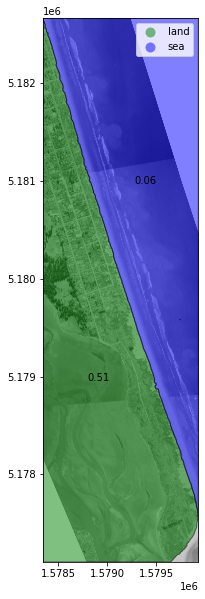

In [10]:
# Plot the results, and check it all looks ok
fig, ax = plt.subplots()
ax = rasterio.plot.show(image, ax=ax)

cmap = matplotlib.colors.ListedColormap(['green', 'blue'])
split_bboxes.plot(ax=ax, alpha=.5, column='class', cmap=cmap, categorical=True, legend=True, edgecolor='black')
split_bboxes.apply(lambda x: ax.annotate(text=round(x.fraction_inland, 2), xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

#relevant_coastline.plot(ax=ax, alpha=.5, edgecolor="cyan")

b = split_bboxes.total_bounds
xlim = ([b[0], b[2]])
ylim = ([b[1], b[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [11]:
name = os.path.splitext(os.path.basename(sample.filename.iloc[0]))[0]
name

'SouthNewBrighton_16AUG1950'

In [12]:
geojson_filename = f"polygon_annotations/{name}.geojson"
split_bboxes.to_file(geojson_filename, driver='GeoJSON')

In [13]:
split_bboxes.crs

<Projected CRS: EPSG:2193>
Name: NZGD2000 / New Zealand Transverse Mercator 2000
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: New Zealand - North Island, South Island, Stewart Island - onshore.
- bounds: (166.37, -47.33, 178.63, -34.1)
Coordinate Operation:
- name: New Zealand Transverse Mercator 2000
- method: Transverse Mercator
Datum: New Zealand Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
image.profile

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': 256.0, 'width': 7727, 'height': 17375, 'count': 3, 'crs': CRS.from_wkt('PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4167"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",173],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1600000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2193"]]'), 'transform': Affine(0.400000000000006, 0.0, 1577556.6100974781,
       0.0, -0.4, 5183399.023433069), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'pixel'}

In [15]:
folder = "training_tiles/" + os.path.splitext(image_filename)[0]
folder

'training_tiles/Retrolens/Canterbury/SouthNewBrighton/Stack/SouthNewBrighton_16AUG1950_mosaic'

In [16]:
if not image.crs and image.gcps:
    image_filename = "temp/" + os.path.basename(image_filename)
    with rasterio.open(image_filename, "w", **image.profile) as dst:
        dst.write(image.read())
        dst.transform = rasterio.transform.from_gcps(image.gcps[0])
        dst.crs = image.gcps[1]
        print(f"Wrote to {image_filename} with corrected CRS")

In [17]:
for bounding_box in tqdm(split_bboxes.envelope):
    with contextlib.redirect_stdout(io.StringIO()):
        raster_tiler = tile.raster_tile.RasterTiler(
            dest_dir=folder,  # the directory to save images to
            src_tile_size=(800, 800),  # the size of the output chips
            verbose=False,
            aoi_boundary=bounding_box,
        )
        raster_bounds_crs = raster_tiler.tile(image_filename, restrict_to_aoi=True, nodata_threshold=.5, dest_fname_base=name)
        vector_tiler = tile.vector_tile.VectorTiler(
            dest_dir=folder,
            verbose=False
        )
        vector_tiler.tile(
            geojson_filename,
            tile_bounds=raster_tiler.tile_bounds,
            tile_bounds_crs=raster_bounds_crs,
            dest_fname_base=name,
        )

  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
coco_geojson = coco.geojson2coco(
    "training_tiles",
    "training_tiles",
    recursive=True,
    output_path=f"coco.json",
    matching_re=r"(\d{7}_\d{7})",
    category_attribute="class",
    explode_all_multipolygons=True,
    verbose=True,
)

  0%|          | 0/153 [00:00<?, ?it/s]